In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [96]:
from gensim.models import KeyedVectors
import nltk
import csv 
from scipy import sparse, stats, spatial
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator
import pickle
import math

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [4]:
model = KeyedVectors.load_word2vec_format('/content/gdrive/My Drive/GoogleNews-vectors-negative300.bin.gz',binary=True)

with open("/content/gdrive/My Drive/RG65.csv", newline="") as f:
    reader = csv.reader(f)
    rg65 = [(row[0].split()[1].split('_')[0], row[1].split()[1].split('_')[0], row[2]) for row in reader]

human_similarity = [float(row[2]) for row in rg65]

In [5]:
cos_similarity = [model.similarity(rg65[i][0], rg65[i][1]) for i in range(len(rg65))]
lst = [(rg65[i][0], rg65[i][1], rg65[i][2], cos_similarity[i]) for i in range(len(rg65))]
df = pd.DataFrame(lst, columns=['word1', 'word2', 'human similarity', 'cosine similarity'])
print(df)

# Compute Pearson correlation between word2vec-based cosine similiarities and human similarities
pearsonr = stats.pearsonr(cos_similarity, human_similarity)
print("Pearson Correlation of word2vec is : {}".format(pearsonr))

         word1      word2 human similarity  cosine similarity
0         cord      smile             0.02           0.018116
1      rooster     voyage             0.04           0.062758
2         noon     string             0.04           0.021655
3        fruit    furnace             0.05           0.073215
4    autograph      shore             0.06           0.034656
..         ...        ...              ...                ...
60     cushion     pillow             3.84           0.251615
61    cemetery  graveyard             3.88           0.642481
62  automobile        car             3.92           0.583837
63      midday       noon             3.94           0.552741
64         gem      jewel             3.94           0.621081

[65 rows x 4 columns]
Pearson Correlation of word2vec is : (0.772061614077633, 5.0910648410367523e-14)


In [107]:
# Open words used for creating LSA vectors
with open("/content/gdrive/My Drive/brown-RG65.csv") as f:
  reader = csv.reader(f)
  brown_rg65 = list(reader)[0]

In [27]:
# Semantic and Syntactic analogy
analogy_file = '/content/gdrive/My Drive/word-test.v1.txt'
with open(analogy_file) as f:
    content = f.readlines()

analogy_pairs = []
semantic_pairs = []
syntactic_pairs = []

syntactic = False
for line in content:
  items = line.split()
  items = [item.lower() for item in items]
  if items[0] == "amazing": syntactic = True # start of syntactic pairs
  result = all(elem in brown_rg65  for elem in items)
  if result and not syntactic: semantic_pairs.append(items)
  if result and syntactic: syntactic_pairs.append(items)

print("Total semantic pairs: ", len(semantic_pairs))
print("Total syntactic pairs: ", len(syntactic_pairs))

# analogy_pairs = [pair for pair in analogy_pairs if len(pair) == 4]
semantic_pairs = [pair for pair in semantic_pairs if len(pair) == 4]
syntactic_pairs = [pair for pair in syntactic_pairs if len(pair) == 4]

def get_accuracy(analogy_pairs):
  n = len(analogy_pairs)
  word1_vec = [model[pair[0]] for pair in analogy_pairs]
  word2_vec = [model[pair[1]] for pair in analogy_pairs]
  word3_vec = [model[pair[2]] for pair in analogy_pairs]
  word4_vec = [model[pair[3]] for pair in analogy_pairs]

  predict_vecs = [word2_vec[i] - word1_vec[i] + word3_vec[i] for i in range(n)]
  predict_word1 = [model.most_similar(positive=[predict_vec], topn=1) for predict_vec in predict_vecs]

  count = 0
  for i in range(n):
    if predict_word1[i][0][0] == analogy_pairs[i][3]: count = count + 1

  accuracy = count / n

  return accuracy

Total semantic pairs:  163
Total syntactic pairs:  2045


In [31]:
# semantic_accuracy = get_accuracy(semantic_pairs)
syntactic_accuracy = get_accuracy(syntactic_pairs)

# print("Semantic Accuracy: ", semantic_accuracy)
print("Syntactic Accuracy: ", syntactic_accuracy)

Syntactic Accuracy:  0.13300733496332517


In [116]:
count = 0
for i in range(n):
  if predict_word1[i][0][0] == analogy_pairs[i][3]: count = count + 1
print(count/n)

0.14861803352967828


In [36]:
# 2. Diachronic word embedding
with open('/content/gdrive/My Drive/embeddings/data.pkl', 'rb') as f:
    diachronic_dict = pickle.load(f)

In [39]:
# Linear transformation to unified the vector coordinate system. 
# Cite: Kulkarni et al. 2015. Statistically Significant Detection of Linguistic Change. International World Wide Web Conference Committee
# Source: https://github.com/viveksck/langchangetrack/blob/master/langchangetrack/utils/LocalLinearRegression.py

'''
    Given a list of numbers, produce a list of weights using the specified kernel
'''
class KernelFunctions:

    @staticmethod
    def uniform(distances):
        return np.ones(len(distances))

class LocalLinearRegression(BaseEstimator):

    def __init__(self, k_nn, weight_func=KernelFunctions.uniform):
        self.k_nn = k_nn
        self.weight_func = weight_func
        print(self.k_nn, self.weight_func)

    '''
        X: A list of points to transform
        Y: The corresponding target points
    '''

    def fit(self, X, Y):
        if len(X) != len(Y):
            raise ValueError("len(X) != len(Y)")
        if len(X) < self.k_nn:
            raise ValueError("Not enough points for local linear regression for the specified number of neighbors (" +
                             str(len(X)) + " < " + str(self.k_nn) + ")")
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.nn = NearestNeighbors(n_neighbors=self.k_nn, algorithm='ball_tree', p=2)
        self.nn.fit(self.X)
        print("Fit the model")

    '''
        X: The point to transform based on its neighbors 
    '''

    def predict(self, X):
        neighbors = self.nn.kneighbors(X)
        distances = neighbors[0][0]
        neighbor_indices = neighbors[1][0]
        local_X = self.X.take(neighbor_indices, axis=0)
        local_Y = self.Y.take(neighbor_indices, axis=0)
        wls = sm.WLS(local_Y, local_X, weights=self.weight_func(distances)).fit()
        return wls.predict(X)

In [40]:
words = diachronic_dict['w']
wordvec = np.array(diachronic_dict['E'])
wordvec_t = np.transpose(wordvec, axes=[1,0,2]) # 10 x 2000 x 300

logistic_model = LocalLinearRegression(k_nn=10)
result = np.zeros((10,2000,300))
# Linear transformation to align vector spaces into one coordinate system. 
for i in range(wordvec_t.shape[0]):
  logistic_model.fit(wordvec_t[i], wordvec_t[-1])
  result[i] = logistic_model.predict(wordvec_t[i])

10 <function KernelFunctions.uniform at 0x7f86cfdc4c80>
Fit the model
Fit the model
Fit the model
Fit the model
Fit the model
Fit the model
Fit the model
Fit the model
Fit the model
Fit the model


In [43]:
# Get the highest distance throughout different time periods. Used for 1st and 2nd techniques. 
def get_lowest_similarity(transpose_matrix): # 2000 x 10 x 300 matrix
  lowest_similarity = []
  for i in range(len(transpose_matrix)):
    t = 1 - distance.cdist(transpose_matrix[i], transpose_matrix[i], metric='cosine')
    lowest_similarity.append(np.nanmin(t))
  return lowest_similarity

# 1st technique. Use original word2vec
original_lowest_similarity = get_lowest_similarity(wordvec)

# 2nd technique. Aligned vector spaces in multiple time period into one unified coordinate system. Cite: Kulkarni et al. 2015
aligned_wordvec = np.transpose(result, axes=[1,0,2])
aligned_lowest_similarity = get_lowest_similarity(aligned_wordvec)


In [47]:
# Find k - nearest neighbors for the words in the latest time period and compare 
# the average distance from the words to the knn in different time period 
def change_in_avg_knn_similarity(transpose_matrix, k = 20):
  knn_variances = []

  print("shape: ",transpose_matrix.shape)
  most_recent_vec = transpose_matrix[-1] 
  t = 1 - distance.cdist(most_recent_vec, most_recent_vec, metric='cosine')
  knn_idxs = np.argsort(t, axis=1)[:,-k:]

  # Compute average similarity to the knn extracted from the latest embeddings
  knn_similarity_matrix = np.zeros((2000,10))
  for i in range(transpose_matrix.shape[0] - 1): 
    for j in range(transpose_matrix[i].shape[0]):
      knn_vec_idx = knn_idxs[j]
      knn_vec = [transpose_matrix[i][idx] for idx in knn_vec_idx]
      t2 = 1 - distance.cdist([transpose_matrix[i][j]], knn_vec, metric='cosine')
      knn_avg_similarity = np.nanmean(t2)
      knn_similarity_matrix[j][i] = knn_avg_similarity
    
  lowest_similarity = np.nanmax(knn_similarity_matrix, axis=1)
  print(lowest_similarity)
  return lowest_similarity

knn_lowest_similarity = change_in_avg_knn_similarity(result)

shape:  (10, 2000, 300)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


[0.71171956 0.63251804 0.78618371 ... 0.6341876  0.42286945 0.50640446]


In [49]:
def print_top_least_changing_words(similarity_list):
  top_changing_words_idx = np.argsort(similarity_list)[:20]
  least_changing_words_idx = np.argsort(similarity_list)[-20:]

  print("*** Top changing words *** ")
  for idx in top_changing_words_idx:
    print(words[idx], similarity_list[idx])

  print("\n")
  print("*** Least changing words *** ")
  for idx in least_changing_words_idx:
    print(words[idx], similarity_list[idx])
  print("\n")

print_top_least_changing_words(original_lowest_similarity)
print_top_least_changing_words(aligned_lowest_similarity)
print_top_least_changing_words(knn_lowest_similarity)

*** Top changing words *** 
objectives 0.001491943793723638
computer 0.0037286989725715536
programs 0.009193959162806187
sector 0.03764294855374328
radio 0.0661023531947148
goals 0.14046733860520855
perspective 0.14433650945483845
shri 0.15008983635207784
impact 0.1519927313047279
approach 0.1601394077183902
van 0.1632516091997943
media 0.16563333662147572
patterns 0.1681395388842808
assessment 0.20347145954888368
berkeley 0.21336943788695795
princeton 0.21725402914976133
shift 0.22306836185908496
therapy 0.22397008919436134
film 0.22408106518013904
j 0.2253758472907864


*** Least changing words *** 
miles 0.6635236269105875
god 0.664478619529633
increase 0.664614595857464
church 0.6651808143340034
river 0.6659556416567358
trees 0.667854533754885
coast 0.669556882874617
husband 0.6696337036219897
july 0.6701699902786664
evening 0.6723988763230423
daughter 0.6799077592476568
century 0.6819516331146491
september 0.6821309871804058
december 0.6862624200128793
june 0.6867559988799217
janu

In [50]:
# Pearson Correlation
all_method_similarity = [original_lowest_similarity, aligned_lowest_similarity, knn_lowest_similarity]
pearcorr = np.zeros((3,3))

for i in range(3):
  for j in range(3):
    pearcorr[i][j] = stats.pearsonr(all_method_similarity[i], all_method_similarity[j])[0]

pearcorr_df = pd.DataFrame(pearcorr, columns=['non_aligned_similarity',
                                              'aligned_similarity',
                                              'aligned_knn_similarity'])

pearcorr_df

,non_aligned_similarity,aligned_similarity,aligned_knn_similarity
0,1.000000,0.254980,0.207737
1,0.254980,1.000000,0.543528
2,0.207737,0.543528,1.000000


In [82]:
def get_largest_subseq_dist(transpose_matrix):

  largest_subseq_gap = []
  period = transpose_matrix.shape[1]
  for i in range(len(transpose_matrix)):
    diach_wordvec = transpose_matrix[i]
    subsequenct_cos_dist = [1 - distance.cdist([diach_wordvec[i]], 
                                          [diach_wordvec[i+1]],
                                          metric='cosine')[0][0] for i in range(period - 1)]
    largest_subseq_gap.append(np.nanmin(subsequenct_cos_dist))

  return largest_subseq_gap

In [41]:
diachronic_dict.keys()

dict_keys(['w', 'd', 'E'])

In [86]:
benchmark = get_largest_subseq_dist(wordvec)
benchmark_aligned = get_largest_subseq_dist(aligned_wordvec)

pearcorr_1 = stats.pearsonr(original_lowest_similarity, benchmark)
pearcorr_2 = stats.pearsonr(aligned_lowest_similarity, benchmark)
pearcorr_3 = stats.pearsonr(knn_lowest_similarity, benchmark)

pearcorr_1_aligned = stats.pearsonr(original_lowest_similarity, benchmark_aligned)
pearcorr_2_aligned = stats.pearsonr(aligned_lowest_similarity, benchmark_aligned)
pearcorr_3_aligned = stats.pearsonr(knn_lowest_similarity, benchmark_aligned)

print("*** NOT-ALIGNED ***")
print("Pearson correlation between evalation benchmark and first method: ", pearcorr_1)
print("Pearson correlation between evalation benchmark and second method: ", pearcorr_2)
print("Pearson correlation between evalation benchmark and third method: ", pearcorr_3)

print("\n*** ALIGNED ***")
print("Pearson correlation between evalation benchmark-aligned and first method: ", pearcorr_1_aligned)
print("Pearson correlation between evalation benchmark-aligned and second method: ", pearcorr_2_aligned)
print("Pearson correlation between evalation benchmark-aligned and third method: ", pearcorr_3_aligned)

*** NOT-ALIGNED ***
Pearson correlation between evalation benchmark and first method:  (0.715257325395965, 3.09015021187e-313)
Pearson correlation between evalation benchmark and second method:  (0.18017137599920124, 4.70046857501786e-16)
Pearson correlation between evalation benchmark and third method:  (0.11742341414772953, 1.392165000782655e-07)

*** ALIGNED ***
Pearson correlation between evalation benchmark-aligned and first method:  (0.1871651109000116, 3.180696813845937e-17)
Pearson correlation between evalation benchmark-aligned and second method:  (0.801018734668688, 0.0)
Pearson correlation between evalation benchmark-aligned and third method:  (0.44357460345425, 3.5080849078811497e-97)


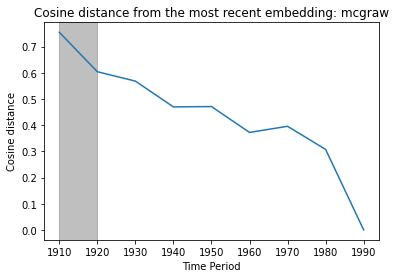

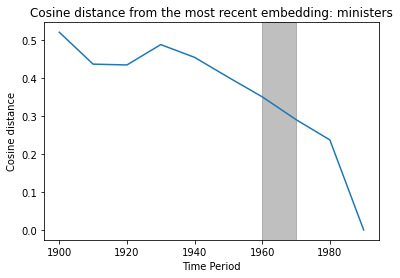

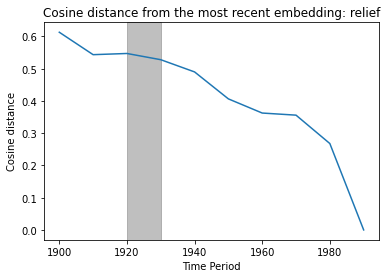

In [104]:
period = diachronic_dict['d']

def get_historical_dist(word, wordvec_mat):
  word_idx = words.index(word)
  diach_wordvec = wordvec_mat[word_idx]
  most_recent_wordvec = diach_wordvec[-1]

  cos_dist_from_recent = [distance.cdist([diach_wordvec[i]], 
                                        [most_recent_wordvec],
                                        metric='cosine')[0][0] for i in range(len(period))]
  
  subsequenct_cos_dist = [distance.cdist([diach_wordvec[i]], 
                                        [diach_wordvec[i+1]],
                                        metric='cosine')[0][0] for i in range(len(period) -1)]
  
  filter_subsequenct_cos_dist = [value for value in subsequenct_cos_dist if not math.isnan(value)]
  largest_val = np.amax(filter_subsequenct_cos_dist)
  largest_dist_idx = np.where(subsequenct_cos_dist==largest_val)[0][0]

  plt.title("Cosine distance from the most recent embedding: {}".format(word))
  plt.xlabel("Time Period")
  plt.ylabel("Cosine distance")
  plt.plot(period, cos_dist_from_recent) 
  plt.axvspan(period[largest_dist_idx], period[largest_dist_idx+1], 
              color='grey', alpha=0.5) # Highlight the largest semantic change. 
  plt.show()

get_historical_dist('mcgraw', wordvec)
get_historical_dist('ministers', wordvec)
get_historical_dist('relief', wordvec)